# ToBig's_11th_W06_Advaced_NN
## Assignment_02 : 2Layer MLP with MNIST data
### 11기 김대웅

## 1. epoch 수정, batch_size수정, Adam 적용, dropout 적용, batchnormalization을 적용해보고 성능이 어떻게 변하는지 확인해보세요

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Loader

In [ ]:
# 불러온 이미지 선처리 하기 위한 단계 (ToTensor : 이미지를 텐서 형태로)
# Tensor의 range는 0에서 1로 

# 이미지 처리를 위한 transforms.Compose
train_dataset = torchvision.datasets.MNIST(root='./data',train=True, download=True,
                                           transform=transforms.Compose([
                                               transforms.ToTensor(), 
                                               transforms.Normalize((0.1307,), (0.3081,))
                                           ]))
                                                                

test_dataset = torchvision.datasets.MNIST(root='./data',train=False, download = True,
                                           transform=transforms.Compose([
                                               transforms.ToTensor(), 
                                               transforms.Normalize((0.1307,), (0.3081,))
                                           ]))
                                                  


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True) # 지정한 batch-size로 묶음

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=128, shuffle=False)

#### 데이터 형태 확인

In [444]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

In [445]:
test_loader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

In [ ]:
examples = iter(train_loader)
example_data, example_targets = next(examples)

In [447]:
example_data.shape

torch.Size([128, 1, 28, 28])

<function matplotlib.pyplot.figure>

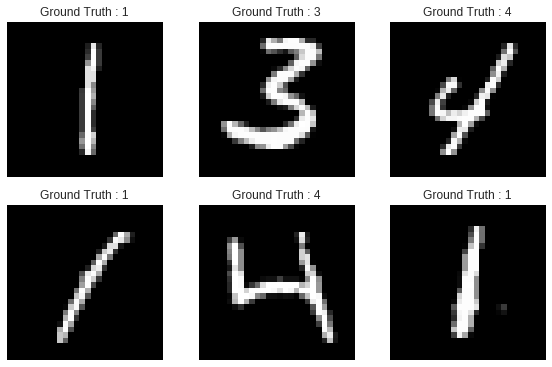

In [448]:
import matplotlib.pyplot as plt
fig = plt.figure
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title("Ground Truth : {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# Model

In [ ]:
# config
src = {'input_size':1*28*28, 
       'hidden_size1':5, 
       'hidden_size2':5,
       'output_size':10,
       'init_weight_range':0.5,
       'num_epochs':5,
       'batch_size':128,
       'learning_rate':1e-3}

In [ ]:
class Net(nn.Module):
    def __init__(self, src):
        super(Net, self).__init__()
        # .Linear Layer
        self.fc1 = nn.Linear(src['input_size'], src['hidden_size1'])
        self.fc2 = nn.Linear(src['hidden_size1'], src['hidden_size2'])
        self.fc3 = nn.Linear(src['hidden_size2'], src['output_size'])
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.init_range = src['init_weight_range']

        
    # 가중치 초기화  (생략가능)
    def init_weight(self):
        self.fc1.weight.data.uniform_(-self.init_range, self.init_range)
        self.fc2.weight.data.uniform_(-self.init_range, self.init_range)
        self.fc3.weight.data.uniform_(-self.init_range, self.init_range)

        '''       
        for fc in self.seq_fc:
            fc.weight.data.uniform_(-self.init_range, self.init_range)
        '''
    # 위에서는 layer 선언만 한 것이지 구체적 적용방법을 설정하지 않음
    # 여기선 구체적인 사용 방법을 설정
    # input data를 선언 (여기선 img)
    def forward(self, img):
        x = img.view(img.shape[0], -1) # image (1 X 3 X 32 X 32)에서 첫 차원은 그대로 두고 뒤 차원들을 다 faltten해 2차원으로 
        # 아래의 과정을 거치겠다.
        #--------------------
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        y = self.fc3(x)
        #--------------------
        

        return y

In [ ]:
model = Net(src)

In [ ]:
y = model(example_data)

In [453]:
print(y.shape)

torch.Size([128, 10])


## Train / Eval
### 손실함수 및 optimizer 정의

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                     src["learning_rate"])

### 1. 기본 모델
- 아무것도 적용하지 않은 기준 모델

In [ ]:
from tqdm import tqdm

In [ ]:
model = Net(src)

In [457]:
model.init_weight()
model.train()

for epoch in tqdm(range(src["num_epochs"])):
    current_loss = 0.0  # loss 초기화.
    
    for i, data in enumerate(train_loader): # 한 번 루프 돌 때마다 Batch-size만큼 처리하도록 trainloader에서 정의함
        # get the inputs
        inputs, labels = data # 사진과 클래스가 묶여 들어가 있으므로
        
        # zero the parameter gradients
        optimizer.zero_grad() # gradient를 iter 돌기 전 초기화 시켜줌
        
        # forward + backward + optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels) # outpuut과 label의 차이를 cross entropy loss로 계산
        loss.backward()
        optimizer.step() # 이를 optim.SGD로 처리후 W를 update
        
        # print statistics
        # 100 step 마다 확인 100step의 평균값(1step은 batch-size만큼의 Loss를 계산함.)
        step = i + 1
        current_loss += loss.item()
        
        if step % 100 == 0 and step !=0:
            print("Epoch [%d/%d], Step [%d/%d], Loss: %.4f" %
                 (epoch + 1, src["num_epochs"], step, len(train_loader)//100*100, current_loss / 100))
            current_loss = 0.0

































  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Step [100/400], Loss: 3.1128
Epoch [1/5], Step [200/400], Loss: 3.1089
Epoch [1/5], Step [300/400], Loss: 3.0893
Epoch [1/5], Step [400/400], Loss: 3.0867


































 20%|██        | 1/5 [00:08<00:34,  8.73s/it]

Epoch [2/5], Step [100/400], Loss: 3.0983
Epoch [2/5], Step [200/400], Loss: 3.0918
Epoch [2/5], Step [300/400], Loss: 3.0696
Epoch [2/5], Step [400/400], Loss: 3.1195


































 40%|████      | 2/5 [00:17<00:26,  8.67s/it]

Epoch [3/5], Step [100/400], Loss: 3.0869
Epoch [3/5], Step [200/400], Loss: 3.0971
Epoch [3/5], Step [300/400], Loss: 3.0823
Epoch [3/5], Step [400/400], Loss: 3.0935


































 60%|██████    | 3/5 [00:26<00:17,  8.72s/it]

Epoch [4/5], Step [100/400], Loss: 3.0931
Epoch [4/5], Step [200/400], Loss: 3.0980
Epoch [4/5], Step [300/400], Loss: 3.0977
Epoch [4/5], Step [400/400], Loss: 3.1007


































 80%|████████  | 4/5 [00:35<00:08,  8.78s/it]

Epoch [5/5], Step [100/400], Loss: 3.0939
Epoch [5/5], Step [200/400], Loss: 3.0798
Epoch [5/5], Step [300/400], Loss: 3.1053
Epoch [5/5], Step [400/400], Loss: 3.1074


































100%|██████████| 5/5 [00:43<00:00,  8.69s/it]

































### 평가 데이터를 이용한 네트워크 평가

In [458]:
# Test the Model
# Test set으로 성능 평가.
correct = 0
total = 0
model.eval()
for i, data in enumerate(test_loader):
    inputs, labels = data
#     images = images.view(-1, 28*28)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.shape[0]
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


10%의 정확도가 나온다.

### 2. batch size 수정 모델
- batch size를 128에서 256로 늘려보았다.

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True) # 지정한 batch-size로 묶음

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=256, shuffle=False)

In [ ]:
model = Net(src)

In [461]:
model.init_weight()
model.train()

for epoch in tqdm(range(src["num_epochs"])):
    current_loss = 0.0  # loss 초기화.
    
    for i, data in enumerate(train_loader): # 한 번 루프 돌 때마다 Batch-size만큼 처리하도록 trainloader에서 정의함
        # get the inputs
        inputs, labels = data # 사진과 클래스가 묶여 들어가 있으므로
        
        # zero the parameter gradients
        optimizer.zero_grad() # gradient를 iter 돌기 전 초기화 시켜줌
        
        # forward + backward + optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels) # outpuut과 label의 차이를 cross entropy loss로 계산
        loss.backward()
        optimizer.step() # 이를 optim.SGD로 처리후 W를 update
        
        # print statistics
        # 100 step 마다 확인 100step의 평균값(1step은 batch-size만큼의 Loss를 계산함.)
        step = i + 1
        current_loss += loss.item()
        
        if step % 100 == 0 and step !=0:
            print("Epoch [%d/%d], Step [%d/%d], Loss: %.4f" %
                 (epoch + 1, src["num_epochs"], step, len(train_loader)//100*100, current_loss / 100))
            current_loss = 0.0

































  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Step [100/200], Loss: 2.6482
Epoch [1/5], Step [200/200], Loss: 2.6515


































 20%|██        | 1/5 [00:08<00:33,  8.37s/it]

Epoch [2/5], Step [100/200], Loss: 2.6553
Epoch [2/5], Step [200/200], Loss: 2.6465


































 40%|████      | 2/5 [00:16<00:25,  8.33s/it]

Epoch [3/5], Step [100/200], Loss: 2.6472
Epoch [3/5], Step [200/200], Loss: 2.6626


































 60%|██████    | 3/5 [00:24<00:16,  8.33s/it]

Epoch [4/5], Step [100/200], Loss: 2.6540
Epoch [4/5], Step [200/200], Loss: 2.6506


































 80%|████████  | 4/5 [00:33<00:08,  8.32s/it]

Epoch [5/5], Step [100/200], Loss: 2.6543
Epoch [5/5], Step [200/200], Loss: 2.6515


































100%|██████████| 5/5 [00:41<00:00,  8.31s/it]

































### 평가 데이터를 이용한 네트워크 평가

In [463]:
# Test the Model
# Test set으로 성능 평가.
correct = 0
total = 0
model.eval()
for i, data in enumerate(test_loader):
    inputs, labels = data
#     images = images.view(-1, 28*28)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.shape[0]
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 7 %


### 3. epoch 수정 모델
- epoch를 5회에서 10회로 늘려보았다.

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True) # 지정한 batch-size로 묶음

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=128, shuffle=False)

# config
src = {'input_size':1*28*28, 
       'hidden_size1':5, 
       'hidden_size2':5,
       'output_size':10,
       'init_weight_range':0.5,
       'num_epochs':10,
       'batch_size':128,
       'learning_rate':1e-3}

In [ ]:
model = Net(src)

In [466]:
model.init_weight()
model.train()

for epoch in tqdm(range(src["num_epochs"])):
    current_loss = 0.0  # loss 초기화.
    
    for i, data in enumerate(train_loader): # 한 번 루프 돌 때마다 Batch-size만큼 처리하도록 trainloader에서 정의함
        # get the inputs
        inputs, labels = data # 사진과 클래스가 묶여 들어가 있으므로
        
        # zero the parameter gradients
        optimizer.zero_grad() # gradient를 iter 돌기 전 초기화 시켜줌
        
        # forward + backward + optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels) # outpuut과 label의 차이를 cross entropy loss로 계산
        loss.backward()
        optimizer.step() # 이를 optim.SGD로 처리후 W를 update
        
        # print statistics
        # 100 step 마다 확인 100step의 평균값(1step은 batch-size만큼의 Loss를 계산함.)
        step = i + 1
        current_loss += loss.item()
        
        if step % 100 == 0 and step !=0:
            print("Epoch [%d/%d], Step [%d/%d], Loss: %.4f" %
                 (epoch + 1, src["num_epochs"], step, len(train_loader)//100*100, current_loss / 100))
            current_loss = 0.0

































  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/400], Loss: 2.8545
Epoch [1/10], Step [200/400], Loss: 2.8513
Epoch [1/10], Step [300/400], Loss: 2.8409
Epoch [1/10], Step [400/400], Loss: 2.8460


































 10%|█         | 1/10 [00:08<01:16,  8.54s/it]

Epoch [2/10], Step [100/400], Loss: 2.8516
Epoch [2/10], Step [200/400], Loss: 2.8475
Epoch [2/10], Step [300/400], Loss: 2.8507
Epoch [2/10], Step [400/400], Loss: 2.8328


































 20%|██        | 2/10 [00:16<01:08,  8.50s/it]

Epoch [3/10], Step [100/400], Loss: 2.8434
Epoch [3/10], Step [200/400], Loss: 2.8445
Epoch [3/10], Step [300/400], Loss: 2.8504
Epoch [3/10], Step [400/400], Loss: 2.8449


































 30%|███       | 3/10 [00:25<00:59,  8.47s/it]

Epoch [4/10], Step [100/400], Loss: 2.8537
Epoch [4/10], Step [200/400], Loss: 2.8548
Epoch [4/10], Step [300/400], Loss: 2.8290
Epoch [4/10], Step [400/400], Loss: 2.8581


































 40%|████      | 4/10 [00:33<00:50,  8.43s/it]

Epoch [5/10], Step [100/400], Loss: 2.8507
Epoch [5/10], Step [200/400], Loss: 2.8343
Epoch [5/10], Step [300/400], Loss: 2.8346
Epoch [5/10], Step [400/400], Loss: 2.8649


































 50%|█████     | 5/10 [00:42<00:42,  8.43s/it]

Epoch [6/10], Step [100/400], Loss: 2.8388
Epoch [6/10], Step [200/400], Loss: 2.8433
Epoch [6/10], Step [300/400], Loss: 2.8271
Epoch [6/10], Step [400/400], Loss: 2.8805


































 60%|██████    | 6/10 [00:50<00:33,  8.44s/it]

Epoch [7/10], Step [100/400], Loss: 2.8413
Epoch [7/10], Step [200/400], Loss: 2.8363
Epoch [7/10], Step [300/400], Loss: 2.8480
Epoch [7/10], Step [400/400], Loss: 2.8626


































 70%|███████   | 7/10 [00:58<00:25,  8.43s/it]

Epoch [8/10], Step [100/400], Loss: 2.8395
Epoch [8/10], Step [200/400], Loss: 2.8522
Epoch [8/10], Step [300/400], Loss: 2.8504
Epoch [8/10], Step [400/400], Loss: 2.8286


































 80%|████████  | 8/10 [01:07<00:16,  8.42s/it]

Epoch [9/10], Step [100/400], Loss: 2.8526
Epoch [9/10], Step [200/400], Loss: 2.8626
Epoch [9/10], Step [300/400], Loss: 2.8289
Epoch [9/10], Step [400/400], Loss: 2.8386


































 90%|█████████ | 9/10 [01:15<00:08,  8.47s/it]

Epoch [10/10], Step [100/400], Loss: 2.8343
Epoch [10/10], Step [200/400], Loss: 2.8537
Epoch [10/10], Step [300/400], Loss: 2.8454
Epoch [10/10], Step [400/400], Loss: 2.8719


































100%|██████████| 10/10 [01:24<00:00,  8.62s/it]

































### 평가 데이터를 이용한 네트워크 평가

In [467]:
# Test the Model
# Test set으로 성능 평가.
correct = 0
total = 0
model.eval()
for i, data in enumerate(test_loader):
    inputs, labels = data
#     images = images.view(-1, 28*28)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.shape[0]
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 9 %


### 4. adam 적용 모델

In [ ]:
# config
src = {'input_size':1*28*28, 
       'hidden_size1':5, 
       'hidden_size2':5,
       'output_size':10,
       'init_weight_range':0.5,
       'num_epochs':5,
       'batch_size':128,
       'learning_rate':1e-3}

model = Net(src)

In [ ]:
optimizer = optim.Adam(model.parameters(),
                     src["learning_rate"])

In [531]:
model.init_weight()
model.train()

for epoch in tqdm(range(src["num_epochs"])):
    current_loss = 0.0  # loss 초기화.
    
    for i, data in enumerate(train_loader): # 한 번 루프 돌 때마다 Batch-size만큼 처리하도록 trainloader에서 정의함
        # get the inputs
        inputs, labels = data # 사진과 클래스가 묶여 들어가 있으므로
        
        # zero the parameter gradients
        optimizer.zero_grad() # gradient를 iter 돌기 전 초기화 시켜줌
        
        # forward + backward + optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels) # outpuut과 label의 차이를 cross entropy loss로 계산
        loss.backward()
        optimizer.step() # 이를 optim.SGD로 처리후 W를 update
        
        # print statistics
        # 100 step 마다 확인 100step의 평균값(1step은 batch-size만큼의 Loss를 계산함.)
        step = i + 1
        current_loss += loss.item()
        
        if step % 100 == 0 and step !=0:
            print("Epoch [%d/%d], Step [%d/%d], Loss: %.4f" %
                 (epoch + 1, src["num_epochs"], step, len(train_loader)//100*100, current_loss / 100))
            current_loss = 0.0




































  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Step [100/400], Loss: 2.2622
Epoch [1/5], Step [200/400], Loss: 2.2041
Epoch [1/5], Step [300/400], Loss: 2.1622
Epoch [1/5], Step [400/400], Loss: 2.1277





































 20%|██        | 1/5 [00:09<00:36,  9.05s/it]

Epoch [2/5], Step [100/400], Loss: 2.0924
Epoch [2/5], Step [200/400], Loss: 2.0757
Epoch [2/5], Step [300/400], Loss: 2.0506
Epoch [2/5], Step [400/400], Loss: 2.0461





































 40%|████      | 2/5 [00:17<00:27,  9.01s/it]

Epoch [3/5], Step [100/400], Loss: 2.0345
Epoch [3/5], Step [200/400], Loss: 2.0151
Epoch [3/5], Step [300/400], Loss: 2.0099
Epoch [3/5], Step [400/400], Loss: 2.0076





































 60%|██████    | 3/5 [00:26<00:17,  8.99s/it]

Epoch [4/5], Step [100/400], Loss: 1.9964
Epoch [4/5], Step [200/400], Loss: 1.9938
Epoch [4/5], Step [300/400], Loss: 1.9776
Epoch [4/5], Step [400/400], Loss: 1.9807





































 80%|████████  | 4/5 [00:35<00:08,  8.98s/it]

Epoch [5/5], Step [100/400], Loss: 1.9650
Epoch [5/5], Step [200/400], Loss: 1.9586
Epoch [5/5], Step [300/400], Loss: 1.9653
Epoch [5/5], Step [400/400], Loss: 1.9581





































100%|██████████| 5/5 [00:44<00:00,  9.00s/it]




































### 평가 데이터를 이용한 네트워크 평가

In [532]:
# Test the Model
# Test set으로 성능 평가.
correct = 0
total = 0
model.eval()

for i, data in enumerate(test_loader):
    inputs, labels = data
#     images = images.view(-1, 28*28)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.shape[0]
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 2500 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 2500 test images: 51 %


51%로 대폭 증가

### 5. Dropout 적용 모델

In [ ]:
class Net(nn.Module):
    def __init__(self, src):
        super(Net, self).__init__()
        # .Linear Layer
        self.fc1 = nn.Linear(src['input_size'], src['hidden_size1'])
        self.fc2 = nn.Linear(src['hidden_size1'], src['hidden_size2'])
        self.fc3 = nn.Linear(src['hidden_size2'], src['output_size'])
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.init_range = src['init_weight_range']

        
    # 가중치 초기화  (생략가능)
    def init_weight(self):
        self.fc1.weight.data.uniform_(-self.init_range, self.init_range)
        self.fc2.weight.data.uniform_(-self.init_range, self.init_range)
        self.fc3.weight.data.uniform_(-self.init_range, self.init_range)

        '''       
        for fc in self.seq_fc:
            fc.weight.data.uniform_(-self.init_range, self.init_range)
        '''
    # 위에서는 layer 선언만 한 것이지 구체적 적용방법을 설정하지 않음
    # 여기선 구체적인 사용 방법을 설정
    # input data를 선언 (여기선 img)
    def forward(self, img):
        x = img.view(img.shape[0], -1) # image (1 X 3 X 32 X 32)에서 첫 차원은 그대로 두고 뒤 차원들을 다 faltten해 2차원으로 
        # 아래의 과정을 거치겠다.
        #--------------------
        x = self.fc1(x)
        x = self.relu1(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = self.relu2(x)
        x = F.dropout(x, training=self.training)
        y = self.fc3(x)
        #--------------------
        

        return y

In [ ]:
model = Net(src)
optimizer = optim.SGD(model.parameters(),
                     src["learning_rate"])

In [474]:
model.init_weight()
model.train()

for epoch in tqdm(range(src["num_epochs"])):
    current_loss = 0.0  # loss 초기화.
    
    for i, data in enumerate(train_loader): # 한 번 루프 돌 때마다 Batch-size만큼 처리하도록 trainloader에서 정의함
        # get the inputs
        inputs, labels = data # 사진과 클래스가 묶여 들어가 있으므로
        
        # zero the parameter gradients
        optimizer.zero_grad() # gradient를 iter 돌기 전 초기화 시켜줌
        
        # forward + backward + optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels) # outpuut과 label의 차이를 cross entropy loss로 계산
        loss.backward()
        optimizer.step() # 이를 optim.SGD로 처리후 W를 update
        
        # print statistics
        # 100 step 마다 확인 100step의 평균값(1step은 batch-size만큼의 Loss를 계산함.)
        step = i + 1
        current_loss += loss.item()
        
        if step % 100 == 0 and step !=0:
            print("Epoch [%d/%d], Step [%d/%d], Loss: %.4f" %
                 (epoch + 1, src["num_epochs"], step, len(train_loader)//100*100, current_loss / 100))
            current_loss = 0.0

































  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Step [100/400], Loss: 4.0545
Epoch [1/5], Step [200/400], Loss: 2.8762
Epoch [1/5], Step [300/400], Loss: 2.6074
Epoch [1/5], Step [400/400], Loss: 2.5004


































 20%|██        | 1/5 [00:08<00:34,  8.70s/it]

Epoch [2/5], Step [100/400], Loss: 2.4177
Epoch [2/5], Step [200/400], Loss: 2.4014
Epoch [2/5], Step [300/400], Loss: 2.3943
Epoch [2/5], Step [400/400], Loss: 2.3755


































 40%|████      | 2/5 [00:17<00:25,  8.67s/it]

Epoch [3/5], Step [100/400], Loss: 2.3570
Epoch [3/5], Step [200/400], Loss: 2.3566
Epoch [3/5], Step [300/400], Loss: 2.3535
Epoch [3/5], Step [400/400], Loss: 2.3463


































 60%|██████    | 3/5 [00:25<00:17,  8.63s/it]

Epoch [4/5], Step [100/400], Loss: 2.3370
Epoch [4/5], Step [200/400], Loss: 2.3353
Epoch [4/5], Step [300/400], Loss: 2.3359
Epoch [4/5], Step [400/400], Loss: 2.3326


































 80%|████████  | 4/5 [00:34<00:08,  8.59s/it]

Epoch [5/5], Step [100/400], Loss: 2.3334
Epoch [5/5], Step [200/400], Loss: 2.3284
Epoch [5/5], Step [300/400], Loss: 2.3239
Epoch [5/5], Step [400/400], Loss: 2.3188


































100%|██████████| 5/5 [00:42<00:00,  8.57s/it]

































### 평가 데이터를 이용한 네트워크 평가

In [476]:
# Test the Model
# Test set으로 성능 평가.
correct = 0
total = 0
model.eval()

for i, data in enumerate(test_loader):
    inputs, labels = data
#     images = images.view(-1, 28*28)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.shape[0]
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 2500 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 2500 test images: 12 %


### 6. batch normalization 적용 모델

In [ ]:
class Net(nn.Module):
    def __init__(self, src):
        super(Net, self).__init__()
        # .Linear Layer
        self.fc1 = nn.Linear(src['input_size'], src['hidden_size1'])
        self.fc2 = nn.Linear(src['hidden_size1'], src['hidden_size2'])
        self.fc3 = nn.Linear(src['hidden_size2'], src['output_size'])
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.init_range = src['init_weight_range']
        self.bn1 = nn.BatchNorm1d(src['hidden_size1'])
        self.bn2 = nn.BatchNorm1d(src['hidden_size2'])
        self.bn3 = nn.BatchNorm1d(src['output_size'])


        
    # 가중치 초기화  (생략가능)
    def init_weight(self):
        self.fc1.weight.data.uniform_(-self.init_range, self.init_range)
        self.fc2.weight.data.uniform_(-self.init_range, self.init_range)
        self.fc3.weight.data.uniform_(-self.init_range, self.init_range)
        self.bn1.weight.data.uniform_(-self.init_range, self.init_range)
        self.bn2.weight.data.uniform_(-self.init_range, self.init_range)
        self.bn3.weight.data.uniform_(-self.init_range, self.init_range)

        '''       
        for fc in self.seq_fc:
            fc.weight.data.uniform_(-self.init_range, self.init_range)
        '''
    # 위에서는 layer 선언만 한 것이지 구체적 적용방법을 설정하지 않음
    # 여기선 구체적인 사용 방법을 설정
    # input data를 선언 (여기선 img)
    def forward(self, img):
        x = img.view(img.shape[0], -1) # image (1 X 3 X 32 X 32)에서 첫 차원은 그대로 두고 뒤 차원들을 다 faltten해 2차원으로 
        # 아래의 과정을 거치겠다.
        #--------------------
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        y = self.bn3(x)
        #--------------------
        

        return y

In [ ]:
model = Net(src)

In [479]:
model.init_weight()
model.train()

for epoch in tqdm(range(src["num_epochs"])):
    current_loss = 0.0  # loss 초기화.
    
    for i, data in enumerate(train_loader): # 한 번 루프 돌 때마다 Batch-size만큼 처리하도록 trainloader에서 정의함
        # get the inputs
        inputs, labels = data # 사진과 클래스가 묶여 들어가 있으므로
        
        # zero the parameter gradients
        optimizer.zero_grad() # gradient를 iter 돌기 전 초기화 시켜줌
        
        # forward + backward + optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels) # outpuut과 label의 차이를 cross entropy loss로 계산
        loss.backward()
        optimizer.step() # 이를 optim.SGD로 처리후 W를 update
        
        # print statistics
        # 100 step 마다 확인 100step의 평균값(1step은 batch-size만큼의 Loss를 계산함.)
        step = i + 1
        current_loss += loss.item()
        
        if step % 100 == 0 and step !=0:
            print("Epoch [%d/%d], Step [%d/%d], Loss: %.4f" %
                 (epoch + 1, src["num_epochs"], step, len(train_loader)//100*100, current_loss / 100))
            current_loss = 0.0

































  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Step [100/400], Loss: 2.3966
Epoch [1/5], Step [200/400], Loss: 2.3933
Epoch [1/5], Step [300/400], Loss: 2.3912
Epoch [1/5], Step [400/400], Loss: 2.3935


































 20%|██        | 1/5 [00:08<00:35,  8.77s/it]

Epoch [2/5], Step [100/400], Loss: 2.3921
Epoch [2/5], Step [200/400], Loss: 2.3927
Epoch [2/5], Step [300/400], Loss: 2.3960
Epoch [2/5], Step [400/400], Loss: 2.3963


































 40%|████      | 2/5 [00:17<00:26,  8.77s/it]

Epoch [3/5], Step [100/400], Loss: 2.3921
Epoch [3/5], Step [200/400], Loss: 2.3957
Epoch [3/5], Step [300/400], Loss: 2.3941
Epoch [3/5], Step [400/400], Loss: 2.3934


































 60%|██████    | 3/5 [00:26<00:17,  8.76s/it]

Epoch [4/5], Step [100/400], Loss: 2.3930
Epoch [4/5], Step [200/400], Loss: 2.3941
Epoch [4/5], Step [300/400], Loss: 2.3932
Epoch [4/5], Step [400/400], Loss: 2.3932


































 80%|████████  | 4/5 [00:35<00:08,  8.75s/it]

Epoch [5/5], Step [100/400], Loss: 2.3980
Epoch [5/5], Step [200/400], Loss: 2.3908
Epoch [5/5], Step [300/400], Loss: 2.3928
Epoch [5/5], Step [400/400], Loss: 2.3912


































100%|██████████| 5/5 [00:43<00:00,  8.73s/it]

































### 평가 데이터를 이용한 네트워크 평가

In [480]:
# Test the Model
# Test set으로 성능 평가.
correct = 0
total = 0
model.eval()

for i, data in enumerate(test_loader):
    inputs, labels = data
#     images = images.view(-1, 28*28)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.shape[0]
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 2500 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 2500 test images: 7 %


# 7. 혼합
- epoch :10
- batch_size : 256
- Adam Optimizer
- dropout
- batch normalization

In [ ]:
# config
src = {'input_size':1*28*28, 
       'hidden_size1':10, 
       'hidden_size2':10,
       'output_size':10,
       'init_weight_range':0.5,
       'num_epochs':10,
       'batch_size':1024,
       'learning_rate':1e-4}

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=src["batch_size"], shuffle=True) # 지정한 batch-size로 묶음
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=src["batch_size"], shuffle=False)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
class Net(nn.Module):
    def __init__(self, src):
        super(Net, self).__init__()
        # .Linear Layer
        self.fc1 = nn.Linear(src['input_size'], src['hidden_size1'])
        self.fc2 = nn.Linear(src['hidden_size1'], src['hidden_size2'])
        self.fc3 = nn.Linear(src['hidden_size2'], src['output_size'])
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.init_range = src['init_weight_range']
        self.bn1 = nn.BatchNorm1d(src['hidden_size1'])
        self.bn2 = nn.BatchNorm1d(src['hidden_size2'])
        self.bn3 = nn.BatchNorm1d(src['output_size'])


        
    # 가중치 초기화  (생략가능)
    def init_weight(self):
        # He 
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        torch.nn.init.kaiming_uniform_(self.fc3.weight)
        self.bn1.weight.data.uniform_(-self.init_range, self.init_range)
        self.bn2.weight.data.uniform_(-self.init_range, self.init_range)
        self.bn3.weight.data.uniform_(-self.init_range, self.init_range)


        '''       
        for fc in self.seq_fc:
            fc.weight.data.uniform_(-self.init_range, self.init_range)
        '''
    # 위에서는 layer 선언만 한 것이지 구체적 적용방법을 설정하지 않음
    # 여기선 구체적인 사용 방법을 설정
    # input data를 선언 (여기선 img)
    def forward(self, img):
        x = img.view(img.shape[0], -1) 
        # 아래의 과정을 거치겠다.
        #--------------------
        x = self.fc1(x)
        x = F.dropout(x, training=self.training)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = F.dropout(x, training=self.training)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        y = self.bn3(x)
        #--------------------
        

        return y

In [ ]:
model = Net(src)

In [ ]:
import numpy as np

In [506]:
model.init_weight()

mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []


for epoch in tqdm(range(src["num_epochs"])):
    #current_loss = 0.0  # loss 초기화.
    model.train()
    
    train_losses = []
    valid_losses = []

    for i, data in enumerate(train_loader): # 한 번 루프 돌 때마다 128개씩 처리하도록 trainloader에서 정의함
        # get the inputs
        inputs, labels = data # 사진과 클래스가 묶여 들어가 있으므로
        
        # zero the parameter gradients
        optimizer.zero_grad() # gradient를 iter 돌기 전 초기화 시켜줌
        
        # forward + backward + optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels) # outpuut과 label의 차이를 cross entropy loss로 계산
        loss.backward()
        optimizer.step() # 이를 optim.SGD로 처리후 W를 update
        
        train_losses.append(loss.item())
        
        if (i * src['batch_size']) % (src['batch_size'] * 100) == 0:
            print(f'{i * 512} / 50000')
        
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
        #     images = images.view(-1, 28*28)
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            valid_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.shape[0]
            correct += (predicted == labels).sum()

    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))

    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))





































  0%|          | 0/10 [00:00<?, ?it/s]

0 / 50000





































 10%|█         | 1/10 [00:09<01:28,  9.83s/it]

epoch : 1, train loss : 2.3412, valid loss : 2.3187, valid acc : 6.00%
0 / 50000





































 20%|██        | 2/10 [00:19<01:18,  9.83s/it]

epoch : 2, train loss : 2.3401, valid loss : 2.3187, valid acc : 6.00%
0 / 50000





































 30%|███       | 3/10 [00:29<01:08,  9.81s/it]

epoch : 3, train loss : 2.3429, valid loss : 2.3184, valid acc : 6.00%
0 / 50000





































 40%|████      | 4/10 [00:39<00:58,  9.81s/it]

epoch : 4, train loss : 2.3426, valid loss : 2.3186, valid acc : 6.00%
0 / 50000





































 50%|█████     | 5/10 [00:48<00:48,  9.78s/it]

epoch : 5, train loss : 2.3421, valid loss : 2.3187, valid acc : 6.00%
0 / 50000





































 60%|██████    | 6/10 [00:58<00:39,  9.78s/it]

epoch : 6, train loss : 2.3414, valid loss : 2.3184, valid acc : 6.00%
0 / 50000





































 70%|███████   | 7/10 [01:08<00:29,  9.77s/it]

epoch : 7, train loss : 2.3430, valid loss : 2.3185, valid acc : 6.00%
0 / 50000





































 80%|████████  | 8/10 [01:18<00:19,  9.79s/it]

epoch : 8, train loss : 2.3413, valid loss : 2.3182, valid acc : 6.00%
0 / 50000





































 90%|█████████ | 9/10 [01:28<00:09,  9.77s/it]

epoch : 9, train loss : 2.3422, valid loss : 2.3187, valid acc : 6.00%
0 / 50000





































100%|██████████| 10/10 [01:37<00:00,  9.79s/it]




































epoch : 10, train loss : 2.3404, valid loss : 2.3187, valid acc : 6.00%


### 평가 데이터를 이용한 네트워크 평가

In [507]:
# Test the Model
# Test set으로 성능 평가.
correct = 0
total = 0
model.eval()

for i, data in enumerate(test_loader):
    inputs, labels = data
#     images = images.view(-1, 28*28)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.shape[0]
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 2500 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 2500 test images: 6 %


#### 다 적용했는데 오히려 성능이 좋지않다.

## 2. 자신이 만든 모델로 test시 실제 값을 맞추지 못한 사진에 대해서 실제 레이블과, 예측한 레이블을 동시에 프린트
- 제일 좋았던 Adam optimizer 적용모델로 해보자

In [ ]:
# config
src = {'input_size':1*28*28, 
       'hidden_size1':5, 
       'hidden_size2':5,
       'output_size':10,
       'init_weight_range':0.5,
       'num_epochs':5,
       'batch_size':128,
       'learning_rate':1e-3}


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=src["batch_size"], shuffle=True) # 지정한 batch-size로 묶음
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=src["batch_size"], shuffle=False)

model = Net(src)

In [ ]:
optimizer = optim.Adam(model.parameters(),
                     src["learning_rate"])

In [535]:
model.init_weight()

for epoch in tqdm(range(src["num_epochs"])):
    current_loss = 0.0  # loss 초기화.
    
    for i, data in enumerate(train_loader): # 한 번 루프 돌 때마다 128개씩 처리하도록 trainloader에서 정의함
        # get the inputs
        inputs, labels = data # 사진과 클래스가 묶여 들어가 있으므로
        
        # zero the parameter gradients
        optimizer.zero_grad() # gradient를 iter 돌기 전 초기화 시켜줌
        
        # forward + backward + optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels) # outpuut과 label의 차이를 cross entropy loss로 계산
        loss.backward()
        optimizer.step() # 이를 optim.SGD로 처리후 W를 update
        
        # print statistics
        # 100 step 마다 확인 = 12800개 image에 대한 loss값 (1step당 128개에 대한 loss이므로)
        # 확인해야 하는 loss는 1회 부터 현재 iter까지 누적된 loss의 평균값
        step = i + 1
        current_loss += loss.item()
        
        if step % 100 == 0 and step !=0:
            print("Epoch [%d/%d], Step [%d/%d], Loss: %.4f" %
                 (epoch + 1, src["num_epochs"], step, len(train_loader)//100 * 100, current_loss / 100))
            current_loss = 0.0




































  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Step [100/400], Loss: 2.2869
Epoch [1/5], Step [200/400], Loss: 2.2049
Epoch [1/5], Step [300/400], Loss: 2.1648
Epoch [1/5], Step [400/400], Loss: 2.1346





































 20%|██        | 1/5 [00:09<00:36,  9.23s/it]

Epoch [2/5], Step [100/400], Loss: 2.0904
Epoch [2/5], Step [200/400], Loss: 2.0674
Epoch [2/5], Step [300/400], Loss: 2.0517
Epoch [2/5], Step [400/400], Loss: 2.0431





































 40%|████      | 2/5 [00:18<00:27,  9.16s/it]

Epoch [3/5], Step [100/400], Loss: 2.0346
Epoch [3/5], Step [200/400], Loss: 2.0127
Epoch [3/5], Step [300/400], Loss: 2.0240
Epoch [3/5], Step [400/400], Loss: 2.0215





































 60%|██████    | 3/5 [00:27<00:18,  9.11s/it]

Epoch [4/5], Step [100/400], Loss: 2.0058
Epoch [4/5], Step [200/400], Loss: 1.9943
Epoch [4/5], Step [300/400], Loss: 1.9919
Epoch [4/5], Step [400/400], Loss: 1.9917





































 80%|████████  | 4/5 [00:36<00:09,  9.08s/it]

Epoch [5/5], Step [100/400], Loss: 1.9914
Epoch [5/5], Step [200/400], Loss: 1.9879
Epoch [5/5], Step [300/400], Loss: 1.9848
Epoch [5/5], Step [400/400], Loss: 1.9856





































100%|██████████| 5/5 [00:45<00:00,  9.08s/it]




































### 평가 데이터를 이용한 네트워크 평가

In [536]:
# Test the Model
# Test set으로 성능 평가.
correct = 0
total = 0
for i, data in enumerate(test_loader):
    inputs, labels = data
#     images = images.view(-1, 28*28)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.shape[0]
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 2500 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 2500 test images: 24 %


<function matplotlib.pyplot.figure>

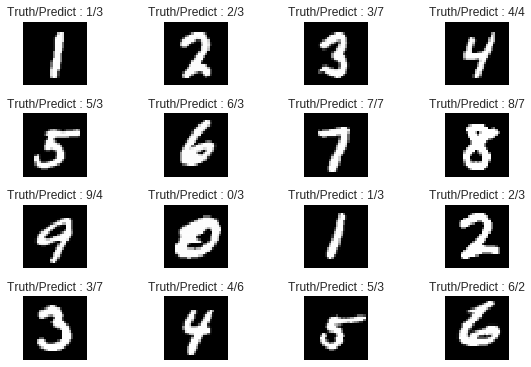

In [537]:
import matplotlib.pyplot as plt
fig = plt.figure
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.tight_layout()
    plt.imshow(inputs[i][0], cmap="gray", interpolation="none")
    plt.title("Truth/Predict : {0}/{1}".format(labels[i], predicted[i]))
    plt.xticks([])
    plt.yticks([])
fig